In [1]:
import numpy as np
import cv2
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt

In [51]:
pcv.params.debug = "none"
pcv.params.dpi = 300

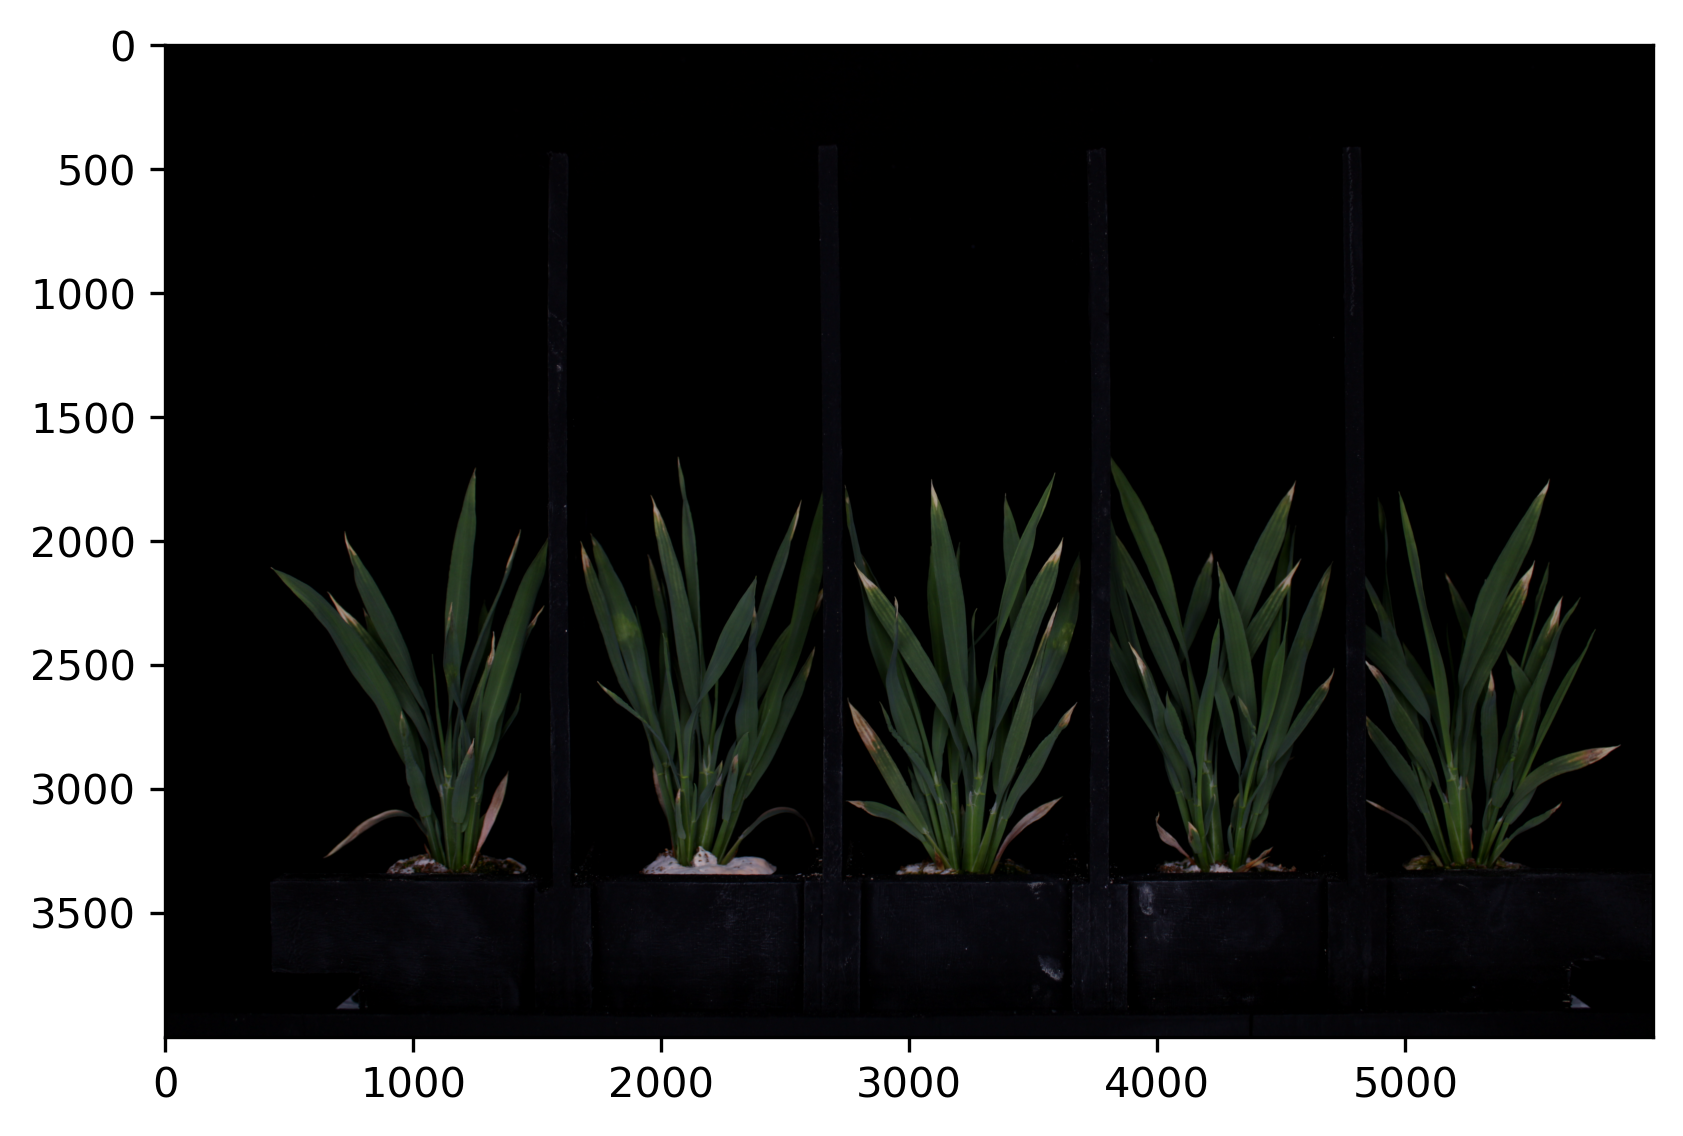

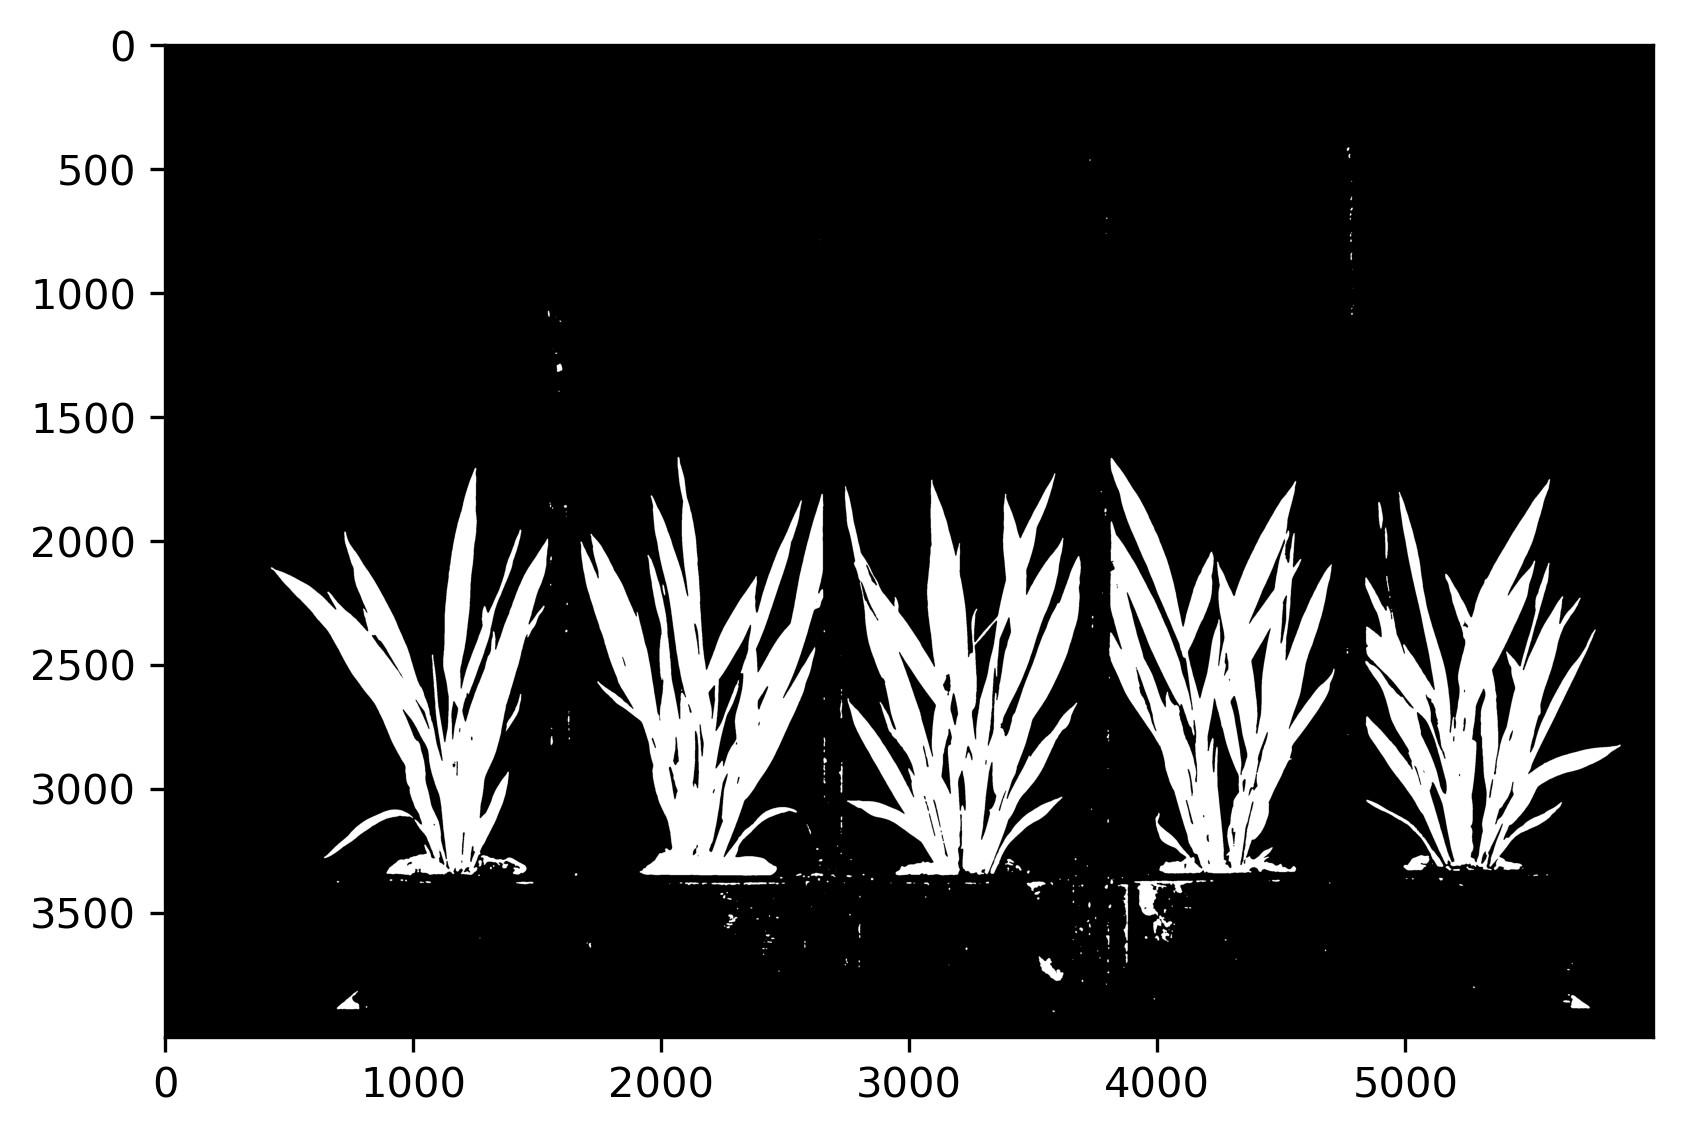

In [57]:
# Let's start by importing one of the standard camera images
img = cv2.imread(filename = "example-images/img1-std.png")
pcv.plot_image(img)

# Then use a classifier trained on other images to segment plant pixels from background pixels
classified = pcv.naive_bayes_classifier(rgb_img=img, 
                                        pdf_file="scripts/classifiers/standard-cam/std-classifier.txt")

# We use the classifications to create a binary mask
mask = pcv.visualize.colorize_masks(masks=[classified['plant'], classified['background']], colors=['white', 'black'])
mask = pcv.rgb2gray(mask)
mask = pcv.median_blur(gray_img = mask, ksize = 8)
pcv.plot_image(mask)

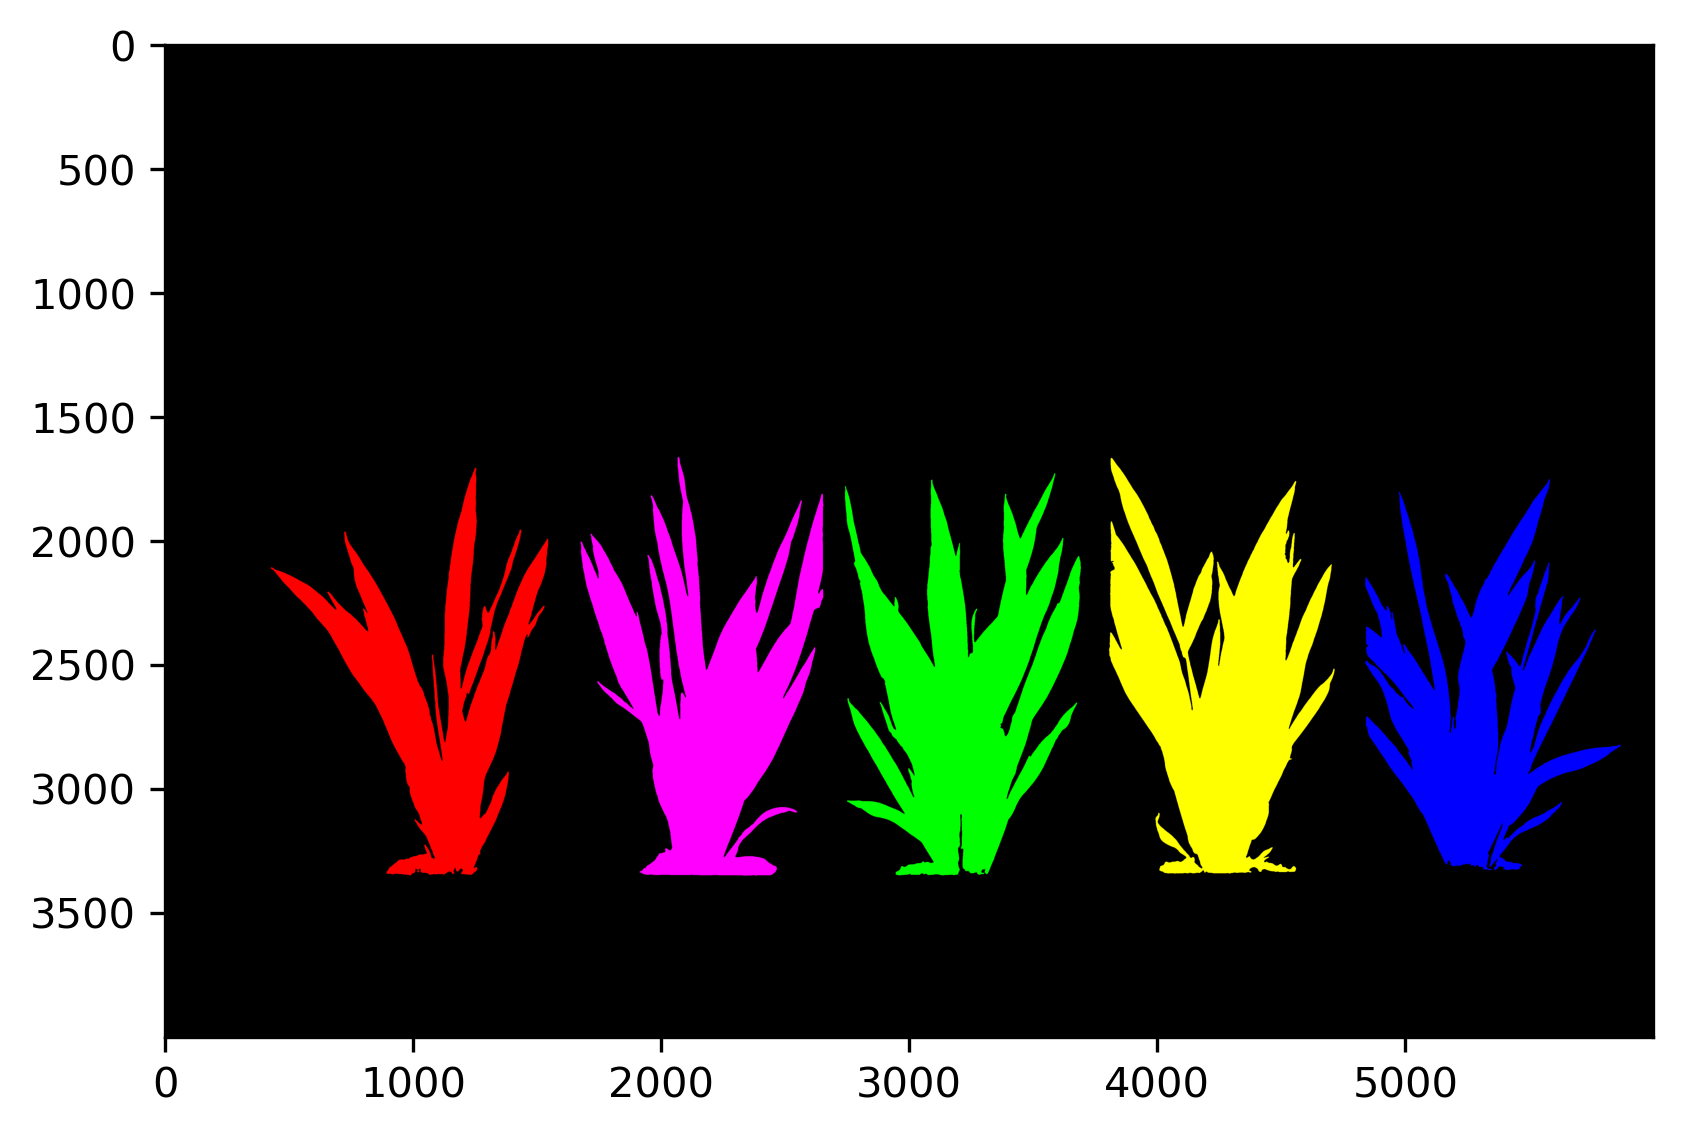

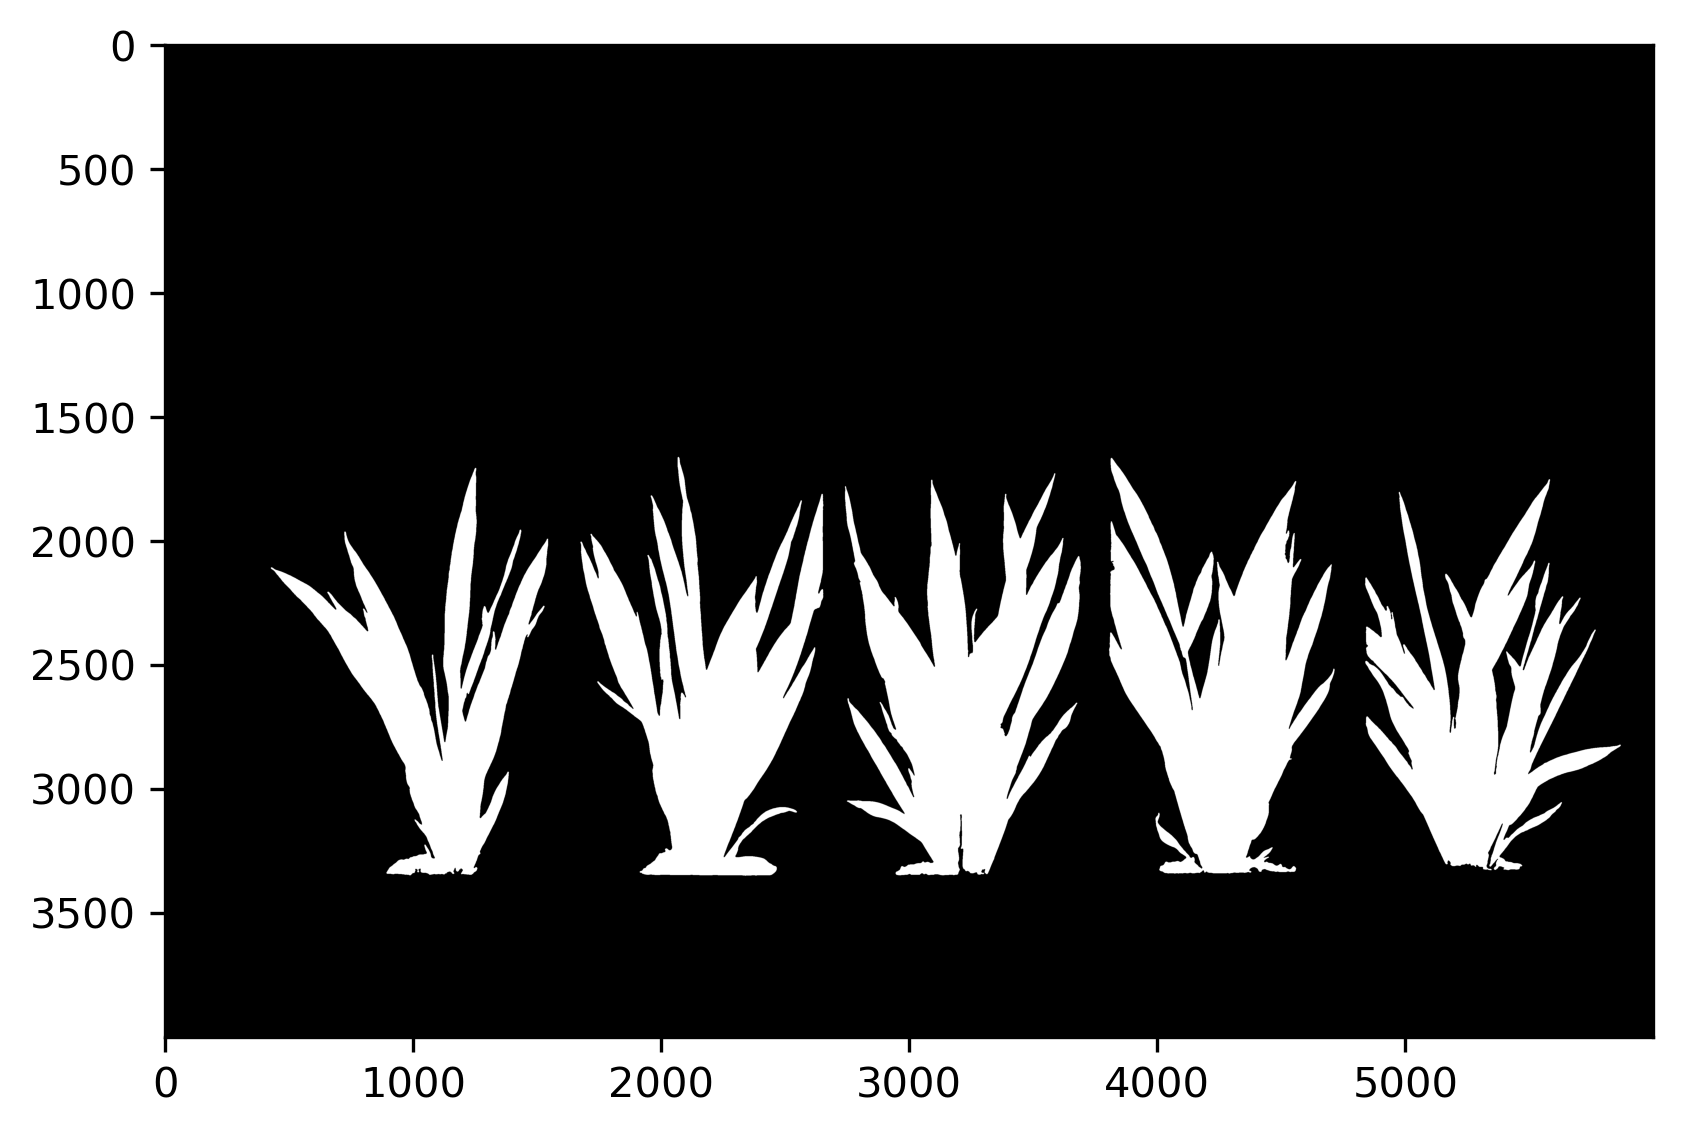

In [117]:
# Now we need to identify individual plants within the image
# we'll accomplish that by finding the contours of every discrete object identified (which includes the noisy bits)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# We can filter the noise by setting a pixel size threshold for objects
# usually this is dynamically passed to the script as an argument, but here we'll set it to 500
obj_size = 2000

# make a blank image to add contours passing the size threshold onto
sanity_check = np.zeros(np.shape(img)[:3], dtype=np.uint8) # to make sure plants are segmented properly
new_mask = np.zeros(np.shape(img)[:2], dtype=np.uint8) # to use as a binary mask later on

# set a palette to be able to discern between objects/contours
colors = [
    (255, 0, 0),   # Red
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (0,255,255),   # Yellow
    (255,0,255)    # Purple
    # Add more colors if you have more contours
]

# iterate over the contours and plot them on the blank image
i = 0
kept_contours = [] # make a list of just the contours passing the size threshold
for c, contour in enumerate(contours):
    if len(contours[c]) > int(obj_size):
        kept_contours.append(contours[c])
        color = colors[i % len(colors)]  # Use modulo to avoid index out of range
        cv2.fillPoly(sanity_check, [contour], color)
        cv2.fillPoly(new_mask, [contour], (255))
        i = i + 1

# Now we see that the mask is significantly cleaned up
# and that each plant has been detected as a distinct object
pcv.plot_image(sanity_check)
pcv.plot_image(new_mask)

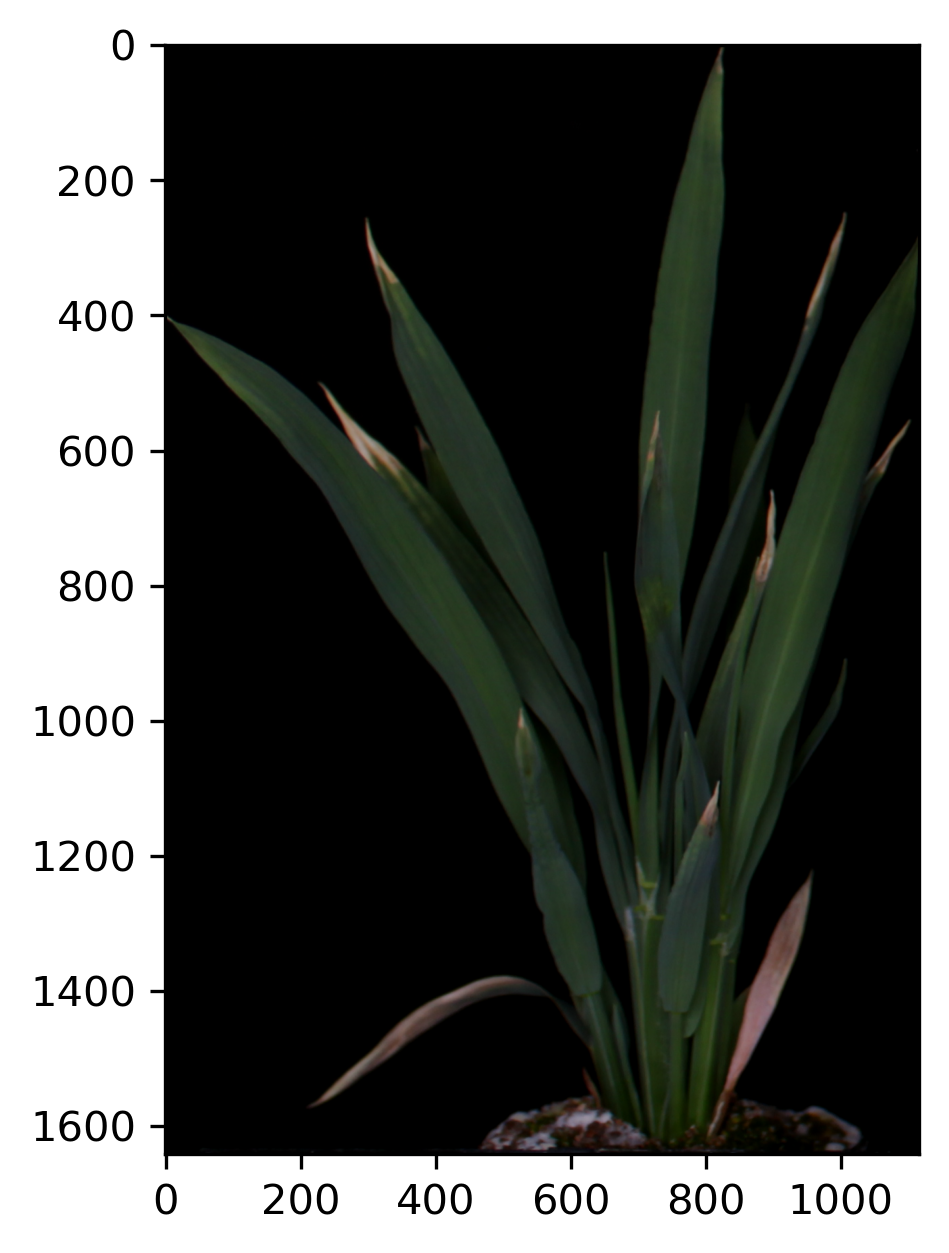

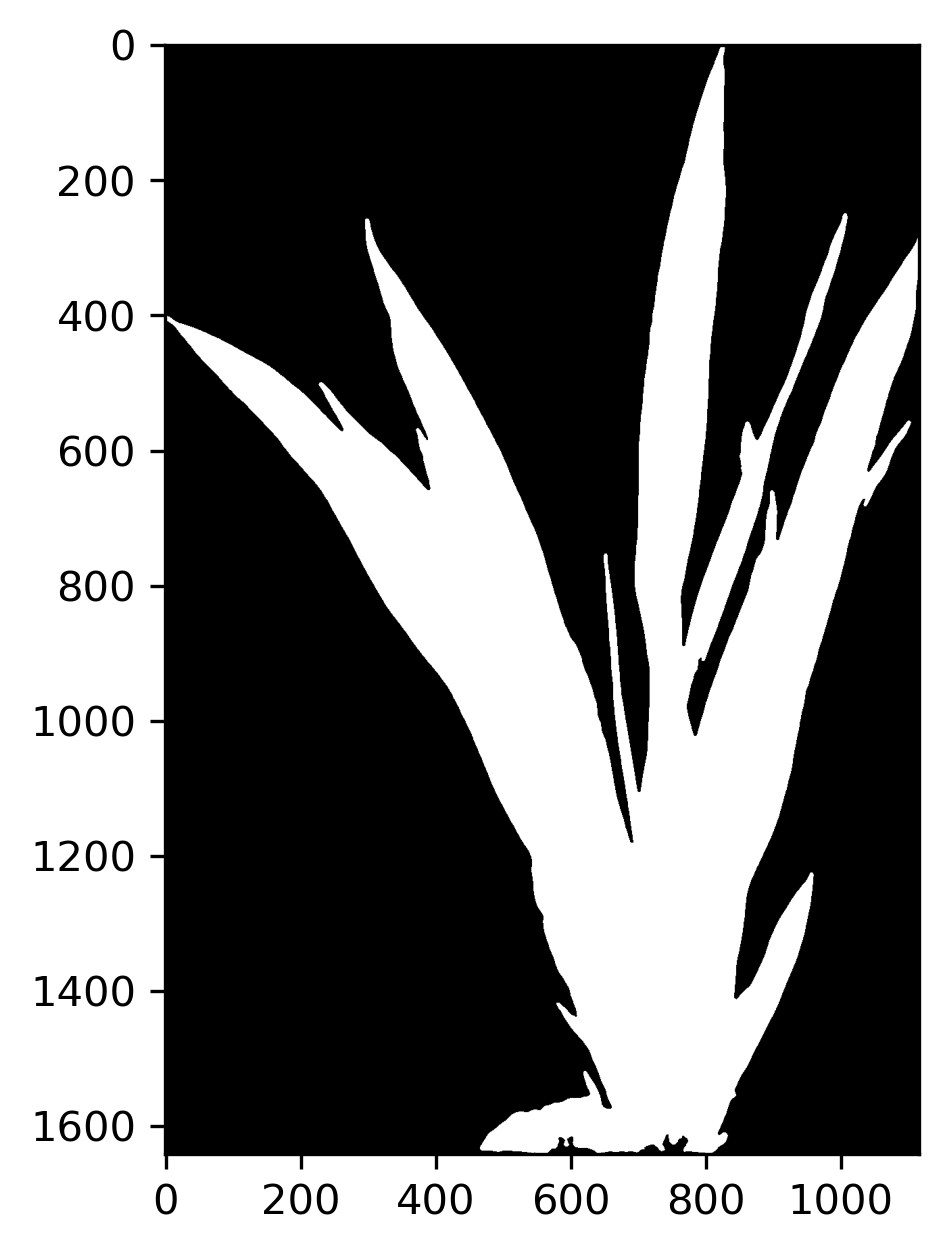

In [124]:
# Iterate over kept contours (i.e. individual plants), crop to contour, store in a dictionary
# This allows us to split images into individual files to pair standard and modified images later
# We do this for both the original image and the mask 

# Identifies the rectangular boundary of each plant 'object'
cropped_images = {}
cropped_masks = {}
i = 0
n = len(kept_contours)
while i < n:
	x_coords = []
	y_coords = []

	m = len(kept_contours[i])
	j = 0
	while j < m:
		x_coords.append(kept_contours[i][j][0][0])
		y_coords.append(kept_contours[i][j][0][1])
		j = j + 1

	x = min(x_coords)
	w = max(x_coords) - min(x_coords)
	y = min(y_coords)
	h = max(y_coords) - min(y_coords)
	cropped_masks[x] = pcv.crop(new_mask, x, y, h, w)
	cropped_images[x] = pcv.crop(img, x, y, h, w)
	i = i + 1
	
# Sort dict by min x, i.e. sort plants left to right, so plants are kept in order
# Allows the addition of a unique plant identifier based on its left-right position
keys = list(cropped_masks.keys())
keys.sort()
images = []
masks = []
for key in keys:
    images.append(cropped_images[key])
    masks.append(cropped_masks[key])

# Let's plot the leftmost plant and its mask
pcv.plot_image(images[0])
pcv.plot_image(masks[0])

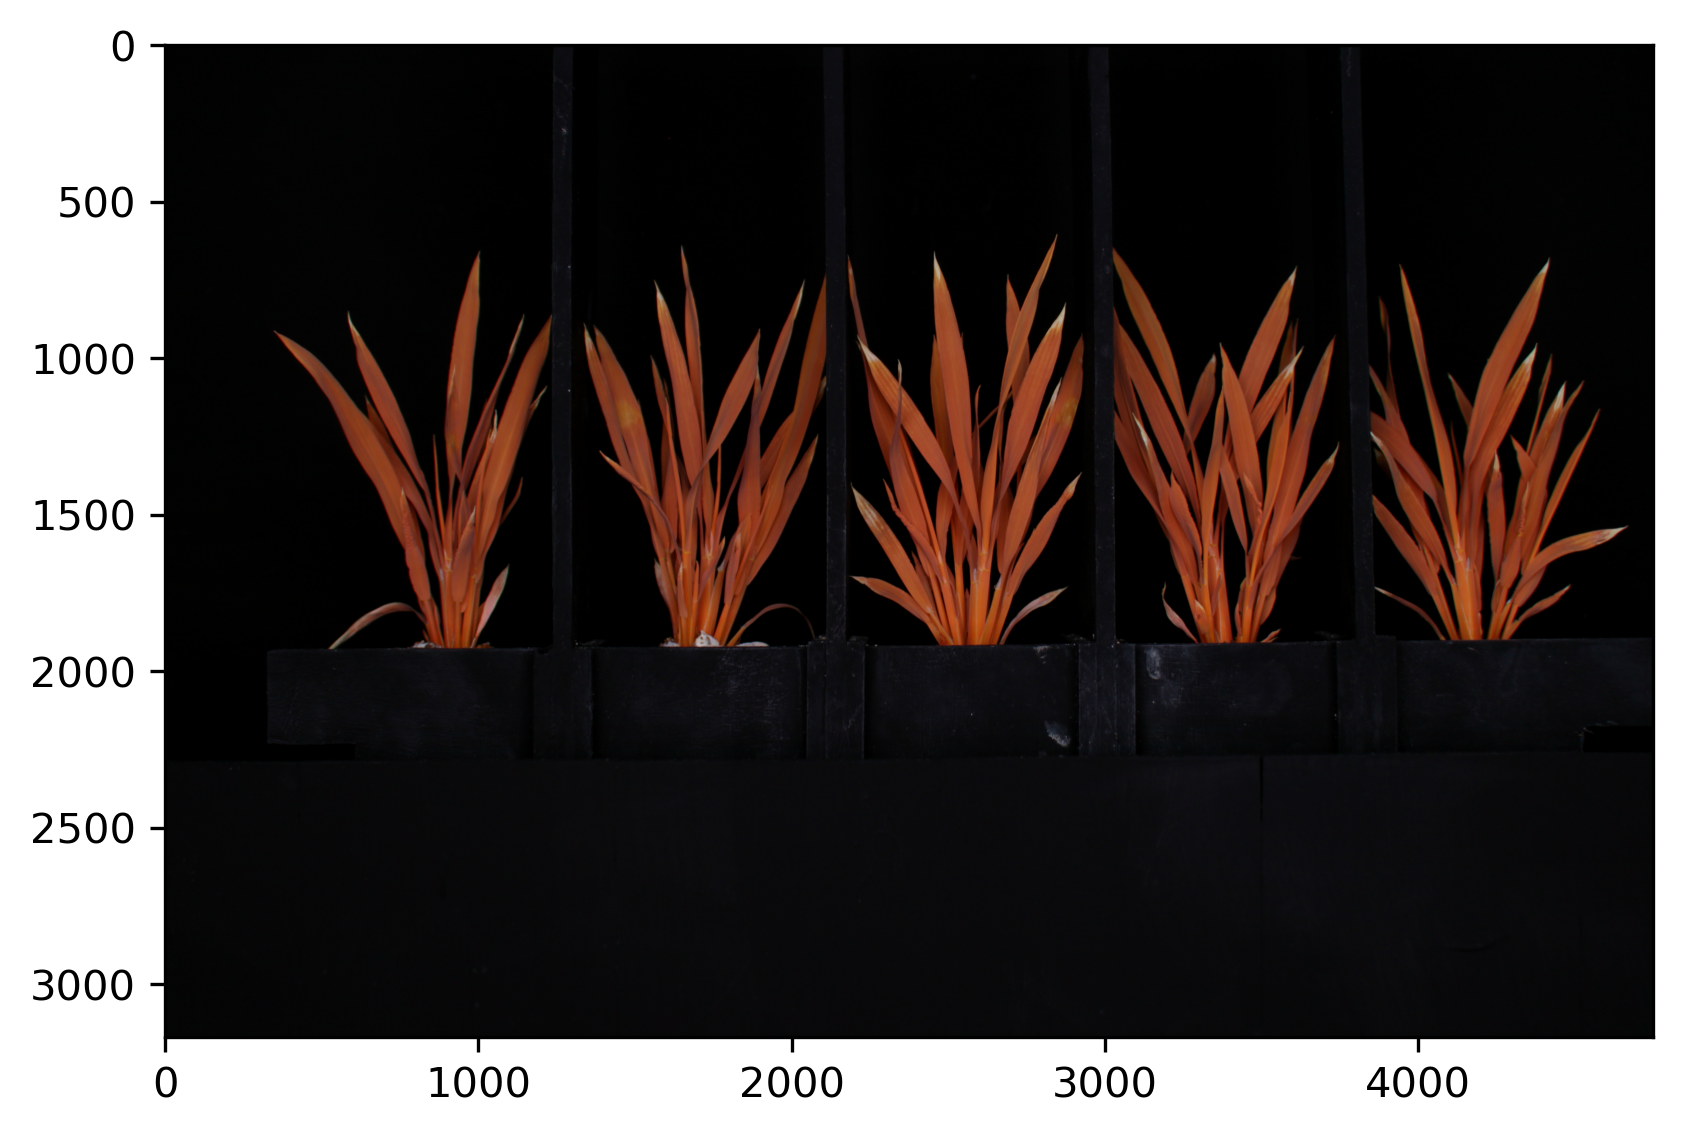

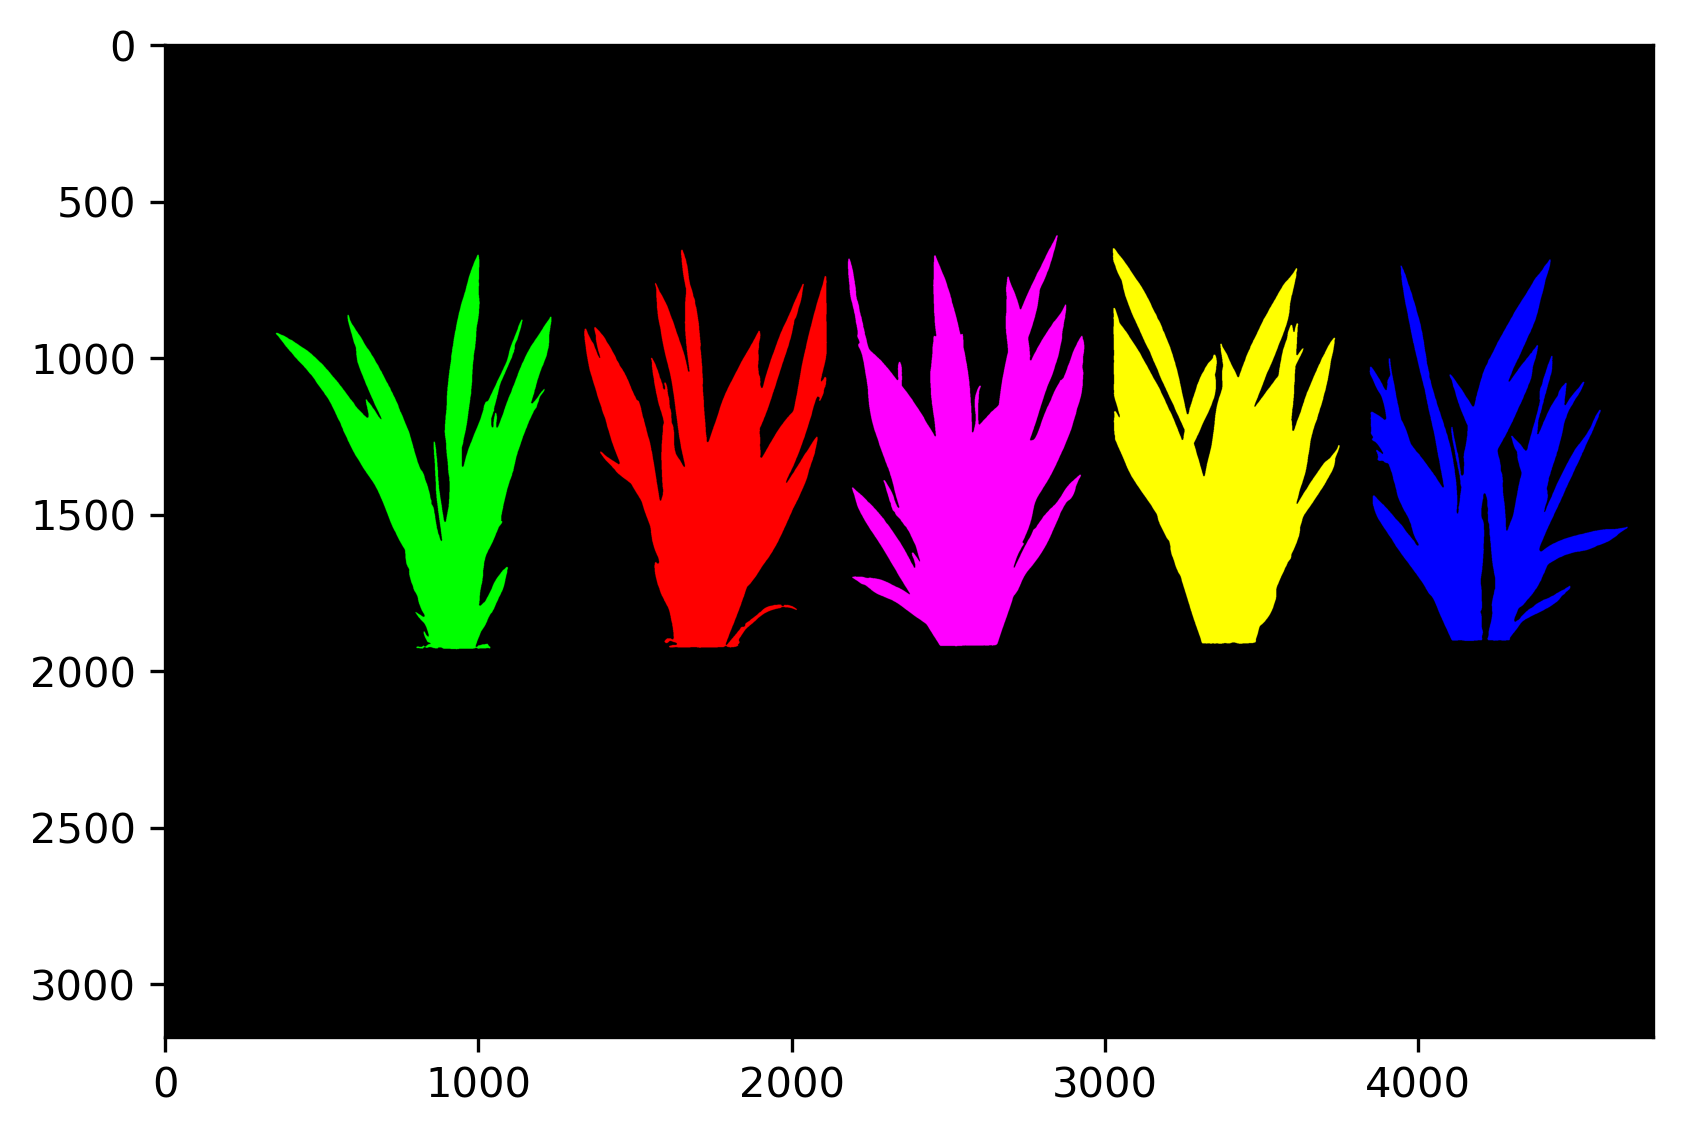

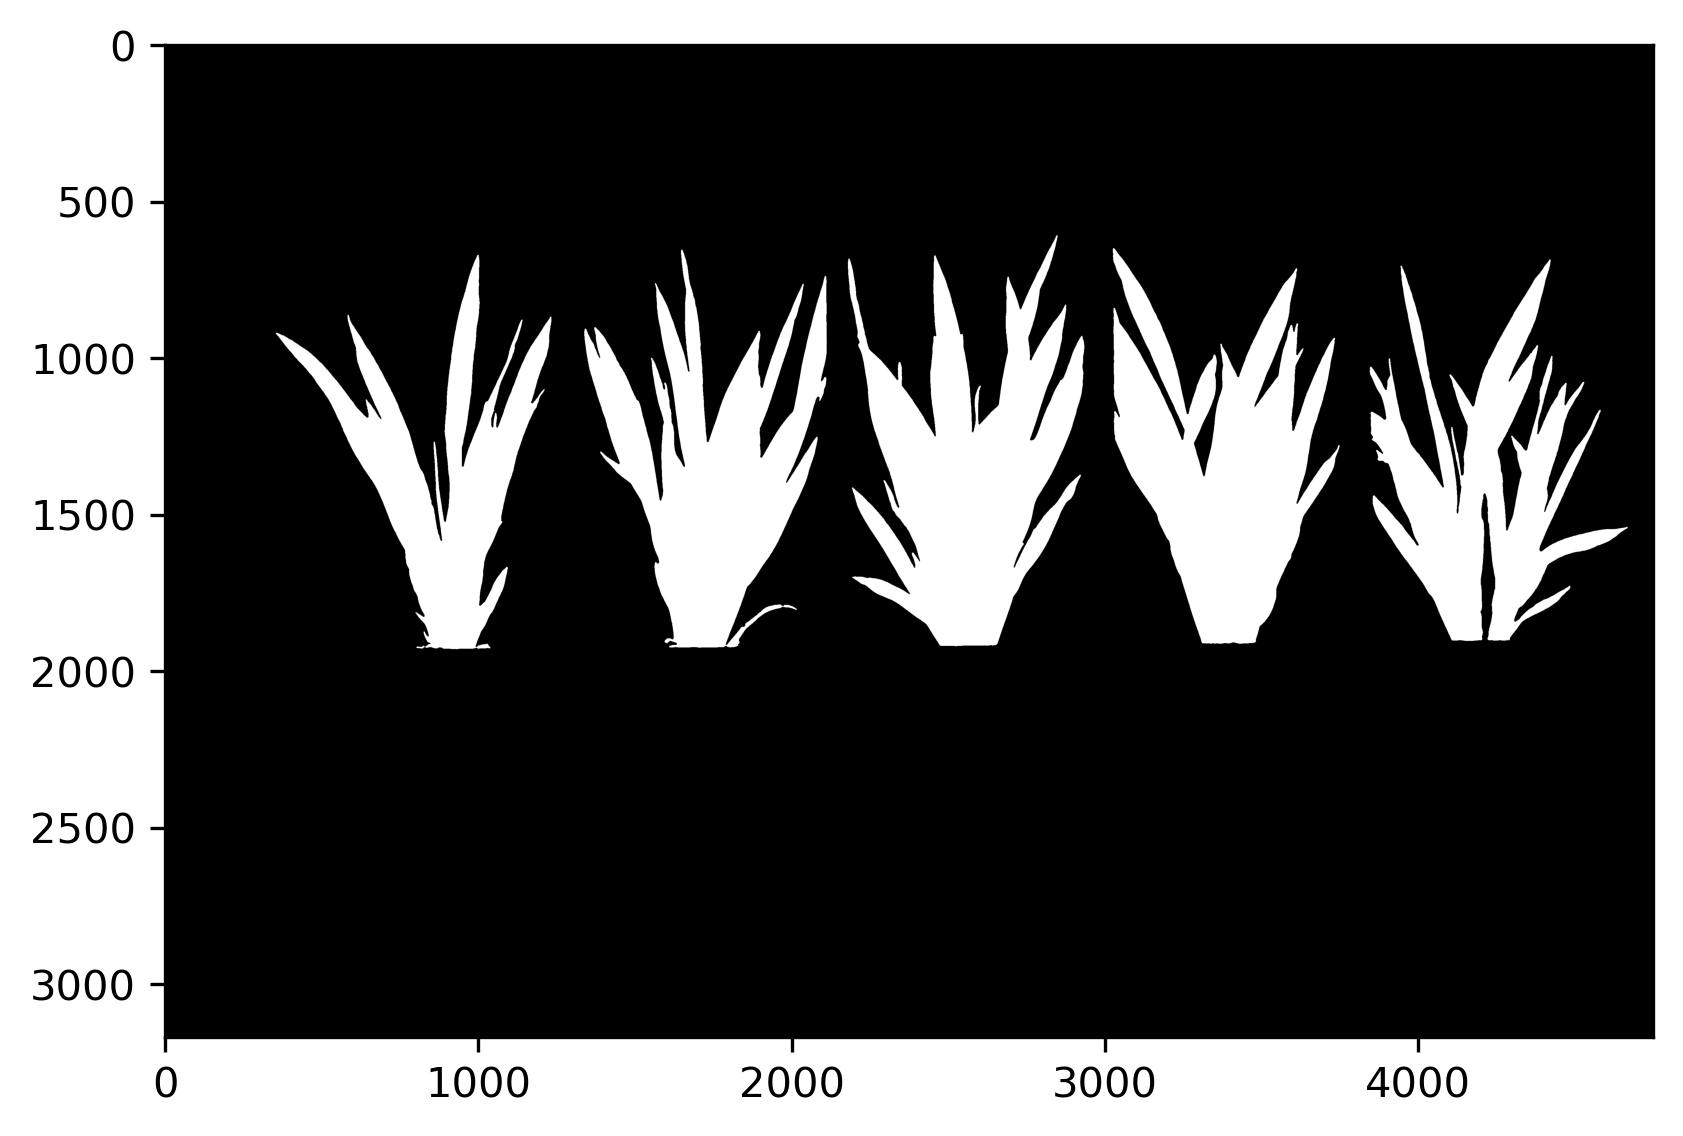

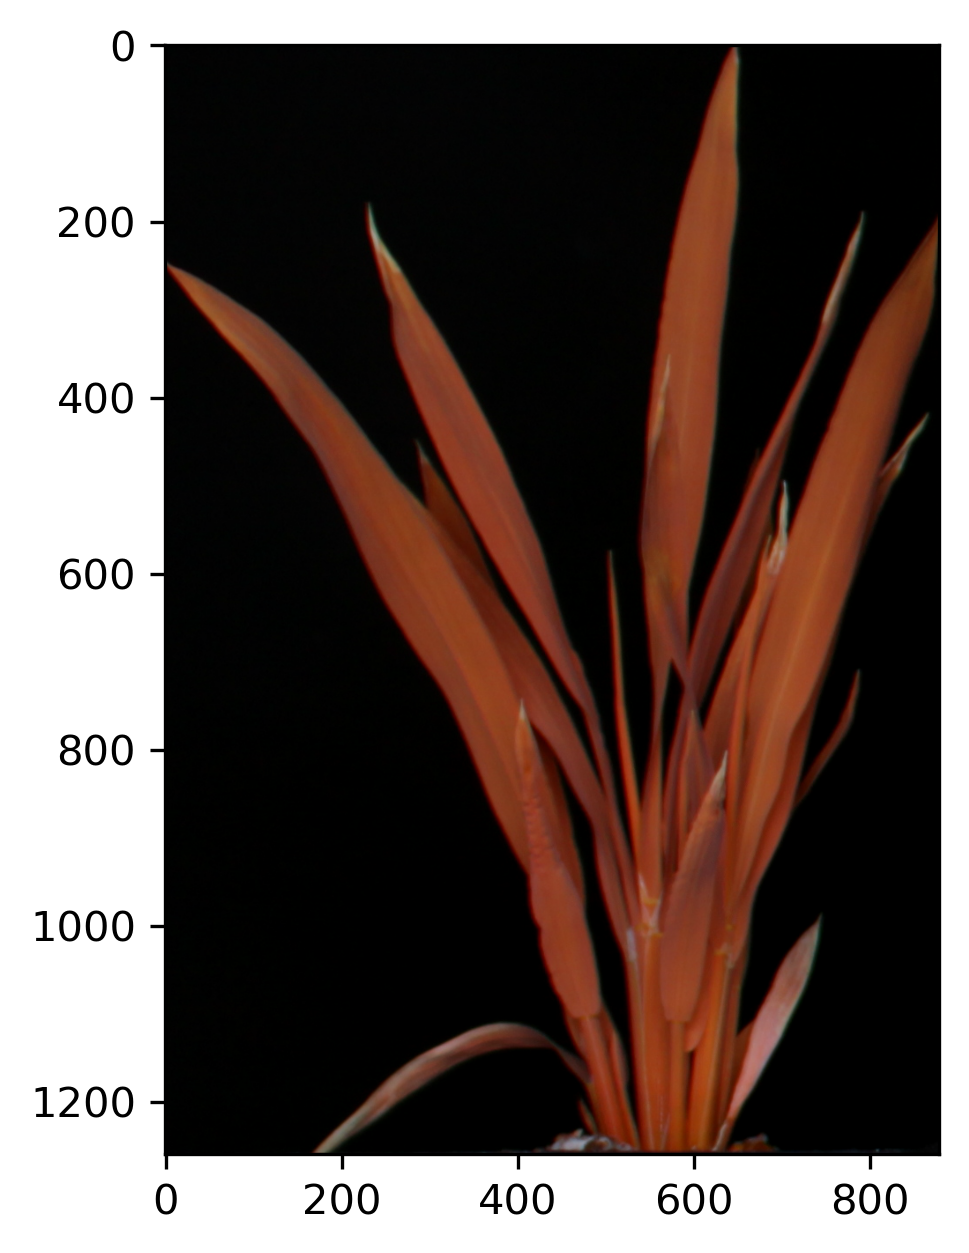

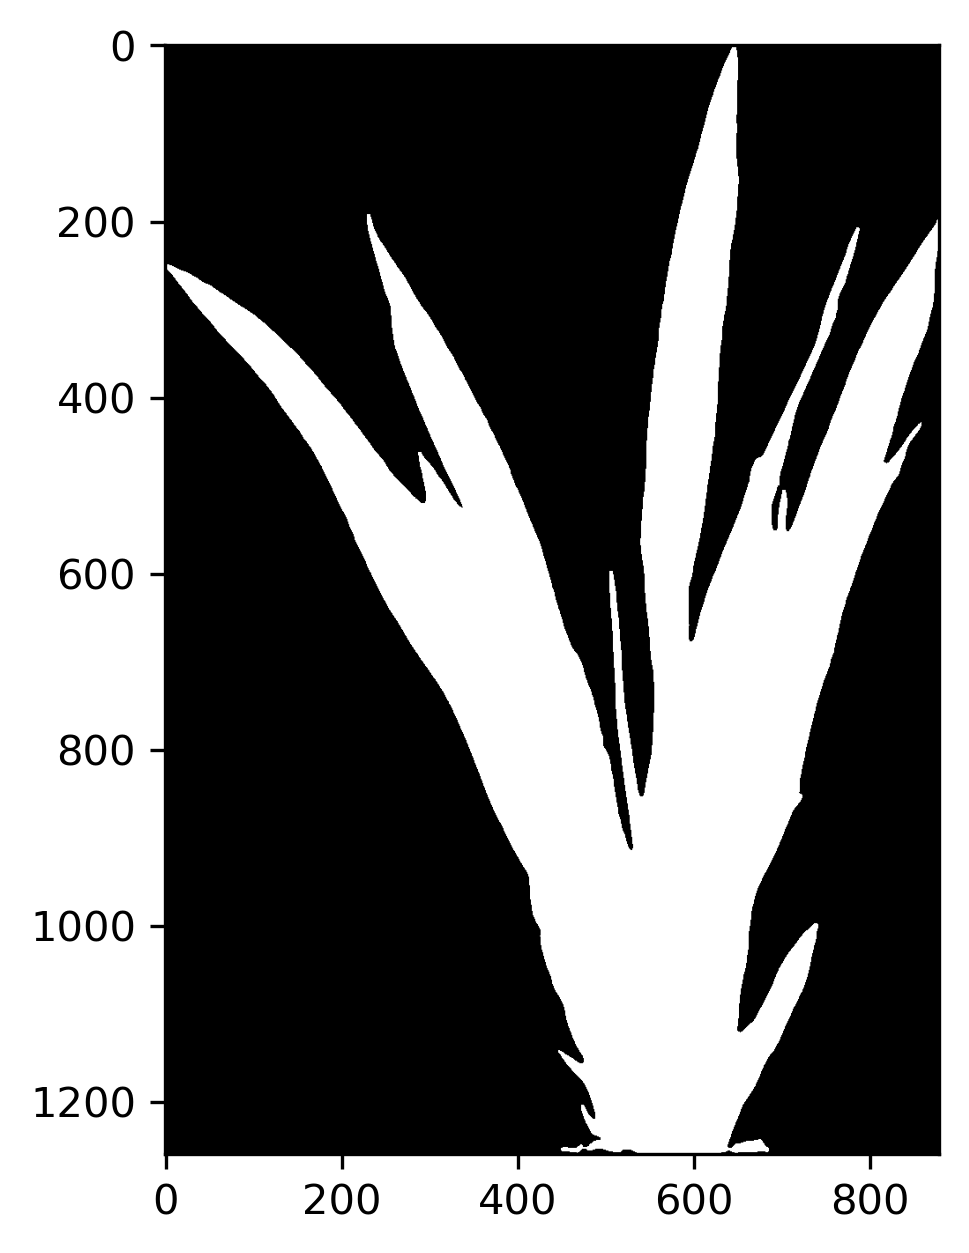

In [153]:
img = cv2.imread(filename = "example-images/img1-mod.png")
pcv.plot_image(img)
classified = pcv.naive_bayes_classifier(rgb_img=img, # make sure to use the mod-classifier
                                        pdf_file="scripts/classifiers/modified-cam/mod-classifier.txt")
mask = pcv.visualize.colorize_masks(masks=[classified['plant'], classified['background']], colors=['white', 'black'])
mask = pcv.rgb2gray(mask)
mask = pcv.median_blur(gray_img = mask, ksize = 8)
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
obj_size = 2000
sanity_check = np.zeros(np.shape(img)[:3], dtype=np.uint8) # to make sure plants are segmented properly
new_mask = np.zeros(np.shape(img)[:2], dtype=np.uint8) # to use as a binary mask later on
colors = [
    (255, 0, 0),   # Red
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (0,255,255),   # Yellow
    (255,0,255)    # Purple
]
i = 0
kept_contours = []
for c, contour in enumerate(contours):
    if len(contours[c]) > int(obj_size):
        kept_contours.append(contours[c])
        color = colors[i % len(colors)]
        cv2.fillPoly(sanity_check, [contour], color)
        cv2.fillPoly(new_mask, [contour], (255))
        i = i + 1
pcv.plot_image(sanity_check)
pcv.plot_image(new_mask)
cropped_images = {}
cropped_masks = {}
i = 0
n = len(kept_contours)
while i < n:
	x_coords = []
	y_coords = []
	m = len(kept_contours[i])
	j = 0
	while j < m:
		x_coords.append(kept_contours[i][j][0][0])
		y_coords.append(kept_contours[i][j][0][1])
		j = j + 1
	x = min(x_coords)
	w = max(x_coords) - min(x_coords)
	y = min(y_coords)
	h = max(y_coords) - min(y_coords)
	cropped_masks[x] = pcv.crop(new_mask, x, y, h, w)
	cropped_images[x] = pcv.crop(img, x, y, h, w)
	i = i + 1
keys = list(cropped_masks.keys())
keys.sort()
images_mod = [] # set unique name for mod
masks_mod = []
for key in keys:
    images_mod.append(cropped_images[key])
    masks_mod.append(cropped_masks[key])

# Let's plot the leftmost plant and its mask
pcv.plot_image(images_mod[0])
pcv.plot_image(masks_mod[0])

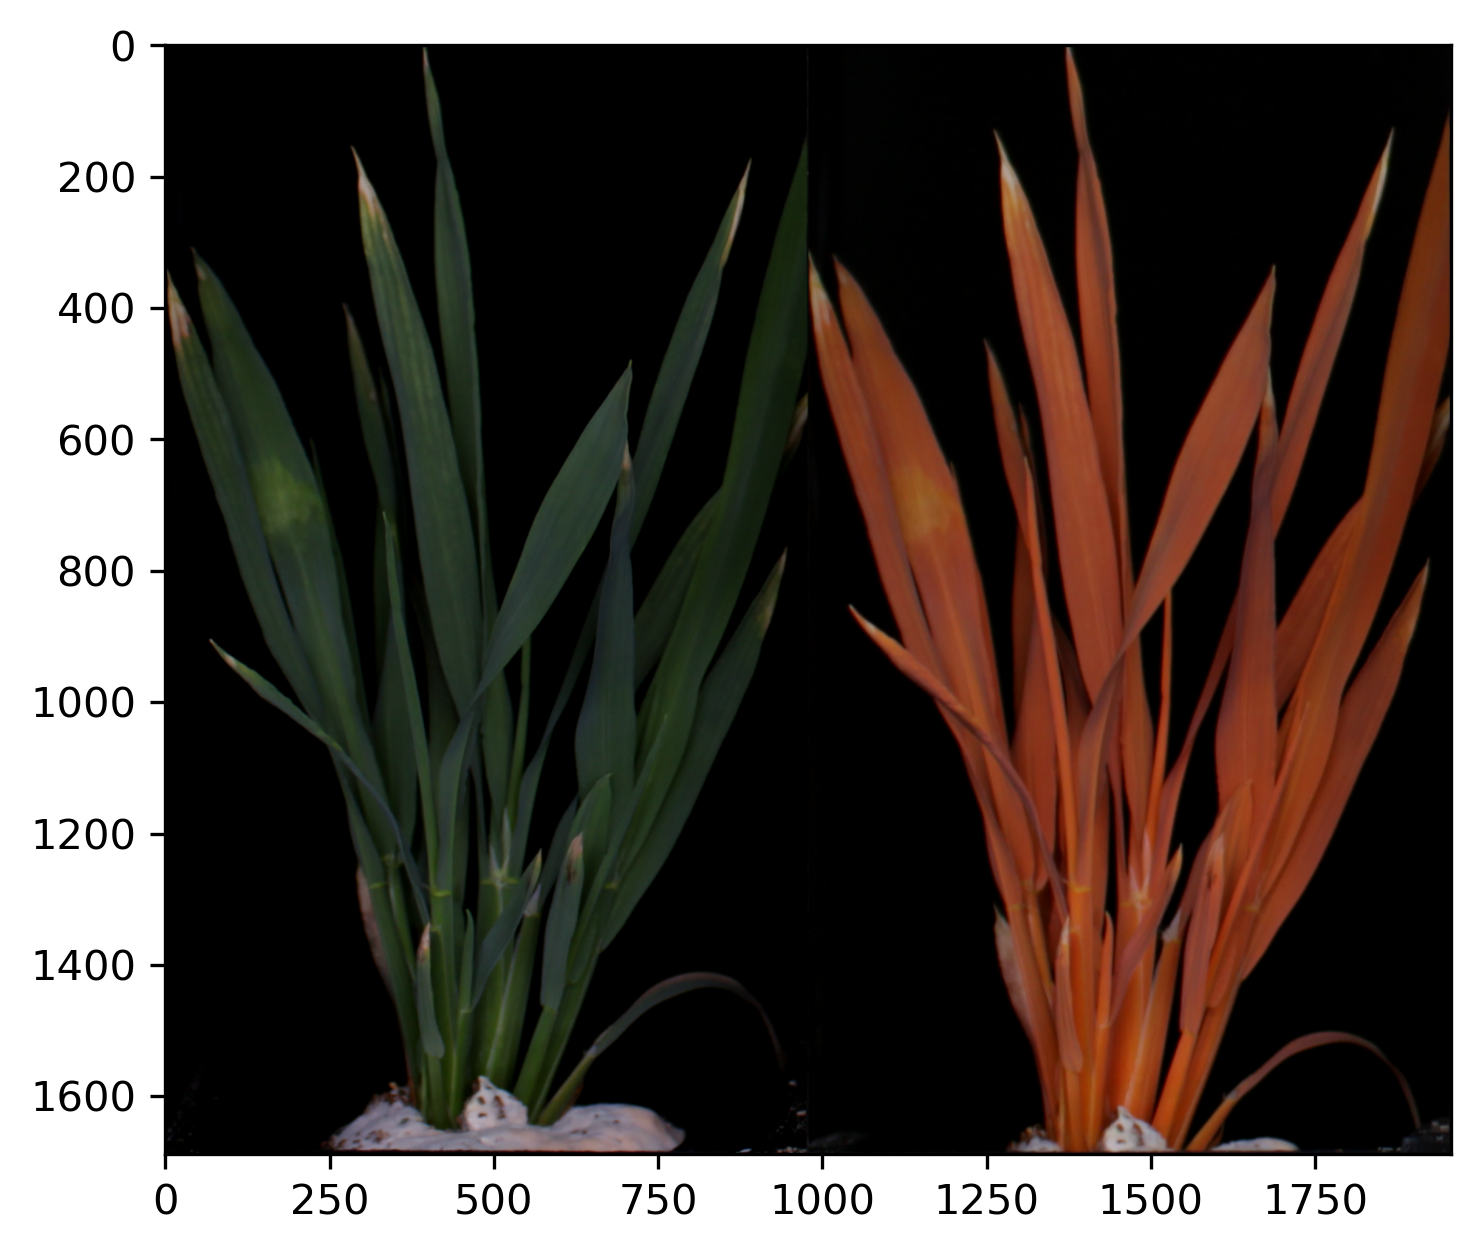

In [193]:
# Let's take a look at the cropped images for an individual plant from each camera
temp = cv2.resize(images_mod[1], dsize=(np.shape(images[1])[1],np.shape(images[1])[0]))
temp = np.concatenate((images[1], temp), axis=1)
pcv.plot_image(temp)

In [455]:
# What we want to do next is extract color space data from each image; with PlantCV it's a pretty easy task
# Start with the standard camera image and we'll extract the frequencies of blue, green, and red pixel intensities
pcv.analyze.color(rgb_img=images[1], labeled_mask=masks[1], colorspaces='all')
red = pcv.outputs.observations['default_1']['red_frequencies']['value']
green = pcv.outputs.observations['default_1']['green_frequencies']['value']
blue = pcv.outputs.observations['default_1']['blue_frequencies']['value']

# Then do the same for the modified camera image
pcv.analyze.color(rgb_img=images_mod[1], labeled_mask=masks_mod[1], colorspaces='all')
red_mod = pcv.outputs.observations['default_1']['red_frequencies']['value']
green_mod = pcv.outputs.observations['default_1']['green_frequencies']['value']
blue_mod = pcv.outputs.observations['default_1']['blue_frequencies']['value']

In [461]:
# Take a look at the data underlying pcv.analyze color which is accessed through pcv.outputs.observations
# What prints below is a list of red pixel intensity frequencies. Intensity ranges from 0-255, so the first
# value in the list indicates that ~4.3% of pixels had a red intensity of 0. Farther down the list you'll find
# that the majority of pixels have red values more normally distributed around 125.
pcv.outputs.observations['default_1']['red_frequencies']['value']

[4.2903854722394446,
 0.31826036526859997,
 0.1985001685601194,
 0.16290215733377966,
 0.14710701327970843,
 0.11528097675284842,
 0.10490804632927926,
 0.08793416018162058,
 0.08345494022598843,
 0.0737892550585717,
 0.06412356989115496,
 0.06459506672858992,
 0.06365207305372,
 0.07426075189600666,
 0.06624530565961229,
 0.05233614895528088,
 0.05610812365476059,
 0.050685910024258506,
 0.04785692899964874,
 0.04997866476810607,
 0.05257189737399836,
 0.05021441318682354,
 0.05375063946758577,
 0.05775836258578296,
 0.05634387207347807,
 0.05634387207347807,
 0.06176608570398014,
 0.057051117329630516,
 0.06577380882217733,
 0.0749679971521591,
 0.06459506672858992,
 0.07968296552650873,
 0.07331775822113673,
 0.07897572027035629,
 0.07708973292061644,
 0.07685398450189895,
 0.07708973292061644,
 0.0839264370634234,
 0.0928848769746877,
 0.0940636190682751,
 0.10514379474799672,
 0.09830709060518977,
 0.10514379474799672,
 0.09547810958057998,
 0.10514379474799672,
 0.110330259959781

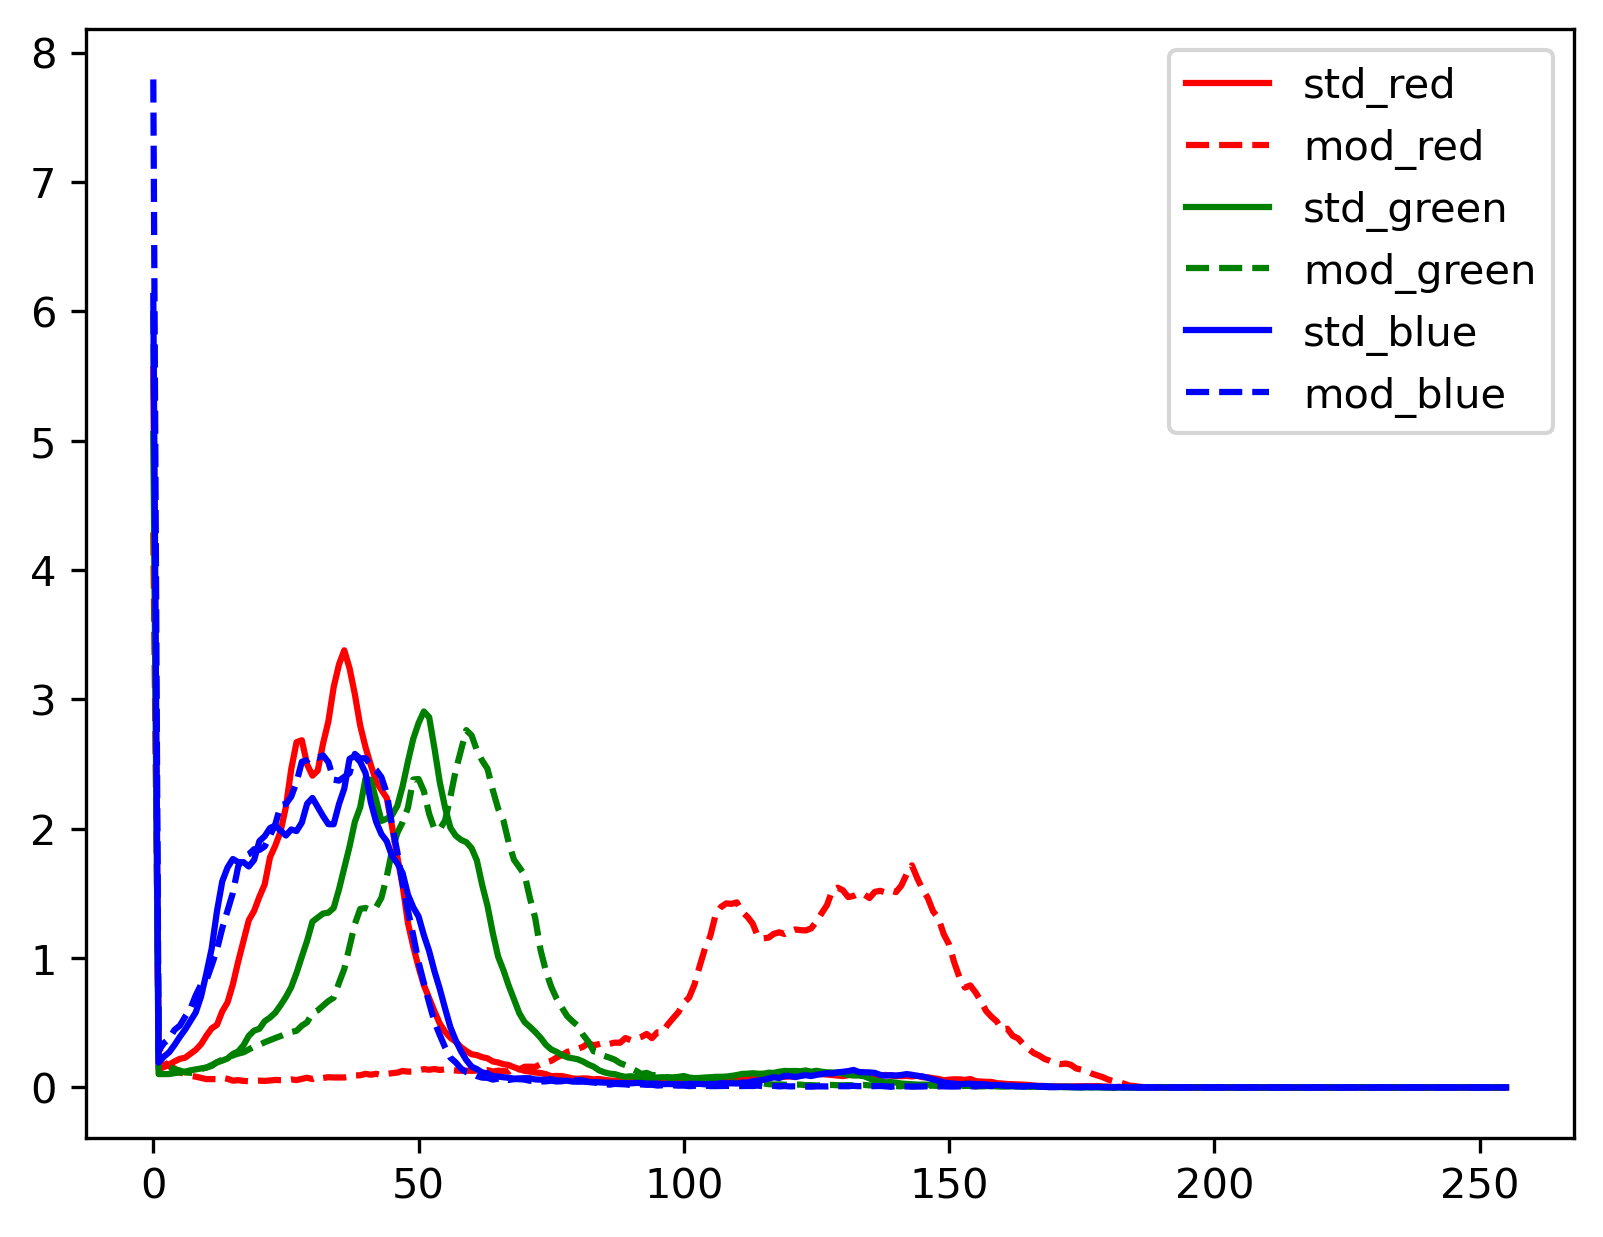

In [459]:
# Since RGB intensity values range between 0-255 we can make an x-axis representing these values
x = np.array(range(0,256))

# Then extract the frequency values for RGB data for each image
y_red = np.array(red)
y_red_mod = np.array(red_mod)
y_green = np.array(green)
y_green_mod = np.array(green_mod)
y_blue = np.array(blue)
y_blue_mod = np.array(blue_mod)

# And plot the data
plt.plot(x, y_red, color='r', label='std_red',)
plt.plot(x, y_red_mod, color='r', label='mod_red', linestyle='dashed')
plt.plot(x, y_green, color='g', label='std_green')
plt.plot(x, y_green_mod, color='g', label='mod_green', linestyle='dashed')
plt.plot(x, blue, color='b', label='std_blue')
plt.plot(x, y_blue_mod, color='b', label='mod_blue', linestyle='dashed')
plt.legend()
plt.show()

# As expected, the blue and green values are largely similar for both images (because the sensors 
# of both cameras have similar sensitivity in their blue and green channels. The red channel, however,
# differs between the two, where the modified camera is able to detect the 730nm light and the standard
# camera is not. From here, we can iterate (and automate) this process over the rest of the images, extract
# the data output by pcv.outputs.observations, and use them to derive NDVI and other useful, biologically-
# relevant data.